Importing Functions

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from scipy import fft
from scipy.stats import gmean
import tqdm
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [136]:
def condense_csv(csv_index,bearing=4):
    '''
    Function to retrieve explanatory variables from signal data
    
    args:
    csv_index = integer value representing which csv we have to read from
    dictionary = False by default, but if user inputs a dictionary 
    '''
    
    data = pd.read_csv(str(csv_index)+'.csv')
    data[['b1x', 'b1y', 'b4x', 'b4y']] = data['b1x;b1y;b4x;b4y'].str.split(';', expand=True)
    data = data.drop(columns=['b1x;b1y;b4x;b4y'])
    data[['b1x', 'b1y', 'b4x', 'b4y']] = data[['b1x', 'b1y', 'b4x', 'b4y']].apply(pd.to_numeric)
    y=list(pd.read_csv('00bearing_conditions.csv').iloc[:,0])


    optional_dict={'x_mean':[],'y_mean':[],
                'x_std':[],'y_std':[],
                'x_rms':[],'y_rms':[],
                'x_sf':[],'y_sf':[],
                'x_peak_count':[],'y_peak_count':[]}
    
    if bearing = 4:

    means=list(data[['b4x', 'b4y']].astype(float).mean())
    stds=list(data[['b4x', 'b4y']].astype(float).std(ddof=1))
    rms=list((data[['b4x', 'b4y']].astype(float)**2).mean()**0.5)

    peakCount=[]
    spectral_flatness=[]

    for axis in ['b'+str(bearing)+'x','b'+str(bearing)+'y']:

        power_spectrum=abs(fft.fft(data[axis].to_numpy()))**2
        spectral_flatness.append(gmean(power_spectrum)/power_spectrum.mean())

        Q1 = data[axis].quantile(0.25)
        Q3 = data[axis].quantile(0.75)
        IQR = Q3 - Q1

        outlierUP = len(np.where(data[axis] >= Q3 + 3*IQR)[0])
        outlierDown = len(np.where(data[axis] <= Q1 - 3*IQR)[0])

        peakCount.append(outlierDown + outlierUP)
    
        optional_dict['x_mean'].append(means[0])
        optional_dict['y_mean'].append(means[1])
        optional_dict['x_std'].append(stds[0])
        optional_dict['y_std'].append(stds[1])
        optional_dict['x_rms'].append(rms[0])
        optional_dict['y_rms'].append(rms[1])
        optional_dict['x_sf'].append(spectral_flatness[0])
        optional_dict['y_sf'].append(spectral_flatness[1])
        optional_dict['x_peak_count'].append(peakCount[0])
        optional_dict['y_peak_count'].append(peakCount[1])
    return means, stds, rms

([-0.09096875, -0.094235205078125],
 [0.06008602164049352, 0.06638162725035471],
 [0.10902048975995292, 0.1152674244979501])

Reading csv files and condensing them

In [150]:
data = pd.read_csv(str(0)+'.csv')
data[['b1x', 'b1y', 'b4x', 'b4y']] = data['b1x;b1y;b4x;b4y'].str.split(';', expand=True)
data = data.drop(columns=['b1x;b1y;b4x;b4y'])
data[['b1x', 'b1y', 'b4x', 'b4y']] = data[['b1x', 'b1y', 'b4x', 'b4y']].apply(pd.to_numeric)

In [ ]:
for i in tqdm.tqdm(range(1724)):
    condense_csv(i,data_bearing_4)
df_bearing_4=pd.DataFrame(data_bearing_4)

In [143]:
y=list(pd.read_csv('00bearing_conditions.csv').iloc[:,0])
data_bearing_1={'x_mean':[],'y_mean':[],
                'x_std':[],'y_std':[],
                'x_rms':[],'y_rms':[],
                'x_sf':[],'y_sf':[],
                'x_peak_count':[],'y_peak_count':[],
                'bearing_condition' : y}
for i in tqdm.tqdm(range(1724)):
    condense_csv(i,data_bearing_1,bearing=1)
df_bearing_1=pd.DataFrame(data_bearing_1)


Exporting condensed files, so that re-condensing isn't necessary as it is quite time intensive

In [142]:
df_bearing_1.to_csv('bearing_1_prediction_data.csv')
df_bearing_4.to_csv('bearing_4_prediction_data.csv')

Exercise 2

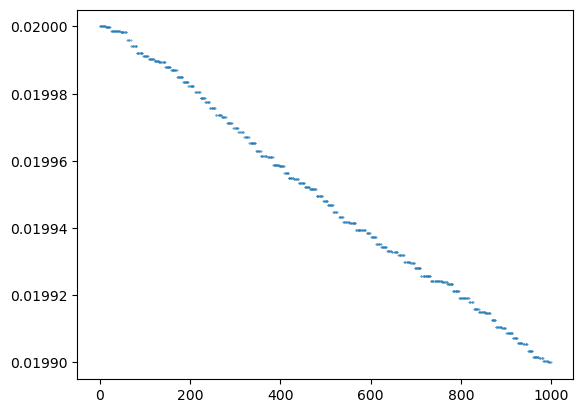

In [146]:
data=pd.read_csv('shaft_radius.csv')
time=data['measurement_index']
train_y,test_y,train_x,test_x=train_test_split(data['shaft_radius'],time,random_state=42,train_size=0.8)
plt.scatter(train_x,train_y,s=0.1)

Text(0, 0.5, 'Predicted Shaft Radius')

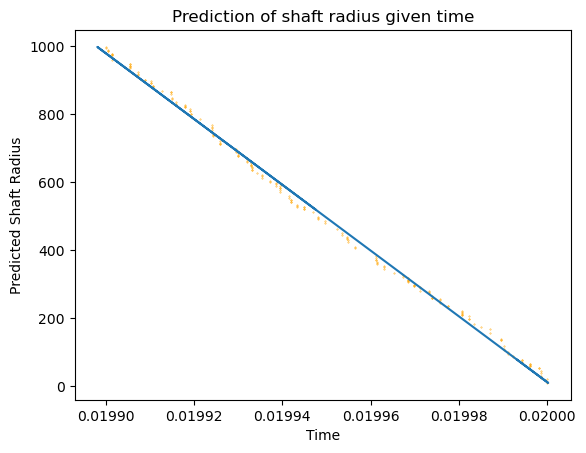

In [147]:
X=sm.add_constant(train_x)
model=sm.OLS(train_y,X).fit()
X_test=sm.add_constant(test_x)
pred=model.predict(X_test)
plt.plot(pred,test_x)
plt.scatter(test_y,test_x,s=0.1,color='orange')
plt.title('Prediction of shaft radius given time')
plt.xlabel('Time')
plt.ylabel('Predicted Shaft Radius')

In [148]:
pears_r=pearsonr(train_y,train_x)[0]
print(f'MSE = {mean_squared_error(test_y,pred)}\n',
      f'Residuals = {sum(test_y-pred)}\n',
      f'R2 Score = {r2_score(test_y,pred)}\n',
      f"Pearson R coefficient for proving linear correlation of data in general = {pears_r}")


MSE = 2.4663831377569095e-12
 Residuals = -2.214063995725074e-05
 R2 Score = 0.9971695469602767
 Pearson R coefficient for proving linear correlation of data in general = -0.9986332649821557
